In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
TRAIN_DIR = r'C:\Users\Sanjeev\Documents\BT Detection\MRI Images\Training'
TEST_DIR  = r'C:\Users\Sanjeev\Documents\BT Detection\MRI Images\Testing'

IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10

# Stable class order
CLASS_NAMES = sorted(os.listdir(TRAIN_DIR))
NUM_CLASSES = len(CLASS_NAMES)

label_map = {name: i for i, name in enumerate(CLASS_NAMES)}
inv_label_map = {i: name for name, i in label_map.items()}

print("Class mapping:", label_map)

Class mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [3]:
def collect_paths(directory):
    paths, labels = [], []
    for label in CLASS_NAMES:
        class_dir = os.path.join(directory, label)
        for img in os.listdir(class_dir):
            paths.append(os.path.join(class_dir, img))
            labels.append(label_map[label])
    return shuffle(paths, labels)

train_paths, train_labels = collect_paths(TRAIN_DIR)
test_paths, test_labels   = collect_paths(TEST_DIR)

In [4]:
def preprocess_train(path):
    img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img = img_to_array(img) / 255.0

    # Light augmentation
    if np.random.rand() < 0.5:
        img = np.flip(img, axis=1)

    return img

In [5]:
def preprocess_test(path):
    img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img = img_to_array(img) / 255.0
    return img

In [6]:
class DataGenerator(Sequence):
    def __init__(self, paths, labels, batch_size, training=True):
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.training = training

    def __len__(self):
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.paths[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_labels = self.labels[idx*self.batch_size:(idx+1)*self.batch_size]

        if self.training:
            images = np.array([preprocess_train(p) for p in batch_paths])
        else:
            images = np.array([preprocess_test(p) for p in batch_paths])

        return images, np.array(batch_labels)

In [7]:
train_gen = DataGenerator(train_paths, train_labels, BATCH_SIZE, training=True)
test_gen  = DataGenerator(test_paths, test_labels, BATCH_SIZE, training=False)

In [8]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

# Freeze backbone
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS
)

c:\Users\Sanjeev\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 610s 2s/step - accuracy: 0.4289 - loss: 1.2680 - val_accuracy: 0.6895 - val_loss: 1.0537
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 642s 2s/step - accuracy: 0.6782 - loss: 0.9359 - val_accuracy: 0.7079 - val_loss: 0.8659
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - accuracy: 0.7537 - loss: 0.7656 - val_accuracy: 0.7361 - val_loss: 0.7668
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 766s 2s/step - accuracy: 0.7834 - loss: 0.6718 - val_accuracy: 0.7559 - val_loss: 0.7017
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 899s 3s/step - accuracy: 0.8018 - loss: 0.6055 - val_accuracy: 0.7681 - val_loss: 0.6616
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 842s 2s/step - accuracy: 0.8169 - loss: 0.5643 - val_accuracy: 0.7765 - val_loss: 0.6264
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 613s 2s/step - accuracy: 0.8277 - loss: 0.5293 - val_accuracy: 0.7857 - val_loss: 0.6017
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 647s 2s/step - accuracy: 0.8374 - loss: 0.4948 - val_accu

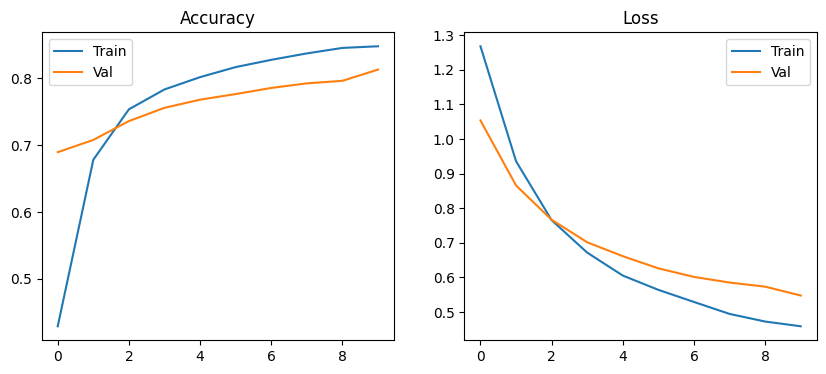

In [10]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.show()

In [21]:
import pandas as pd

history_df = pd.DataFrame({
    'epoch': range(1, EPOCHS + 1),
    'train_accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'],
    'train_loss': history.history['loss'],
    'val_loss': history.history['val_loss']
})

history_df.to_csv('training_history.csv', index=False)


In [11]:
test_images = np.array([preprocess_test(p) for p in test_paths])
test_preds  = model.predict(test_images)
test_preds_cls = np.argmax(test_preds, axis=1)

print(classification_report(test_labels, test_preds_cls, target_names=CLASS_NAMES))

41/41 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step
              precision    recall  f1-score   support

      glioma       0.83      0.75      0.79       300
  meningioma       0.67      0.63      0.65       306
     notumor       0.91      0.90      0.91       405
   pituitary       0.81      0.95      0.87       300

    accuracy                           0.81      1311
   macro avg       0.80      0.81      0.80      1311
weighted avg       0.81      0.81      0.81      1311



In [12]:
import pandas as pd

results_df = pd.DataFrame({
    "image_path": test_paths,
    "true_label": [inv_label_map[i] for i in test_labels],
    "predicted_label": [inv_label_map[i] for i in test_preds_cls],
    "confidence": np.max(test_preds, axis=1)
})

results_df["correct"] = results_df["true_label"] == results_df["predicted_label"]

results_df.to_csv("brain_tumor_predictions.csv", index=False)


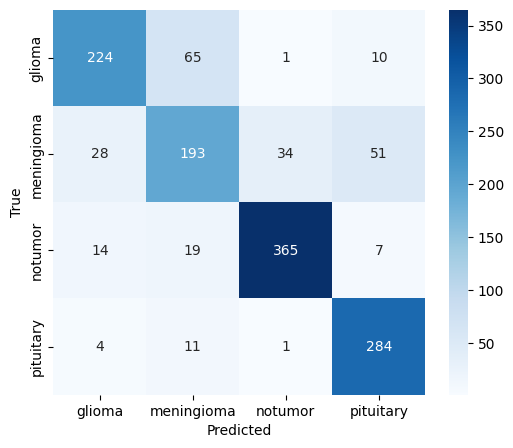

In [13]:
cm = confusion_matrix(test_labels, test_preds_cls)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [14]:
cm_df = pd.DataFrame(
    cm,
    index=CLASS_NAMES,
    columns=CLASS_NAMES
)
cm_df.to_csv("confusion_matrix.csv")


In [15]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    test_labels, test_preds_cls
)

metrics_df = pd.DataFrame({
    "class": CLASS_NAMES,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "support": support
})

metrics_df.to_csv("class_metrics.csv", index=False)


In [16]:
model.save('brain_tumor_vgg16.h5')
model = load_model('brain_tumor_vgg16.h5')

In [17]:
def predict_image(img_path):
    img = preprocess_test(img_path)
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)[0]
    idx = np.argmax(preds)

    label = inv_label_map[idx]
    confidence = preds[idx] * 100

    plt.imshow(load_img(img_path))
    plt.axis('off')
    plt.title(f"{label} ({confidence:.2f}%)")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


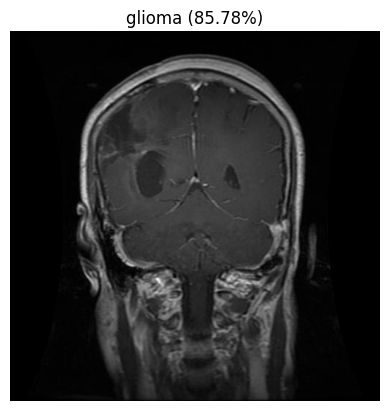

In [19]:
predict_image(r'C:\Users\Sanjeev\Documents\BT Detection\MRI Images\Training\glioma\Tr-gl_0010.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


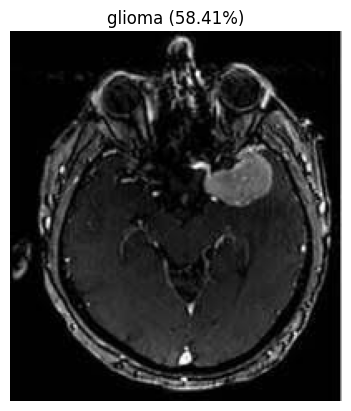

In [20]:
predict_image(r'C:\Users\Sanjeev\Documents\BT Detection\MRI Images\Testing\meningioma\Te-me_0011.jpg')
